# Measures branching in C++ from python

This notebook looks into a couple of ways to write code, which one is efficient, which one is not when it comes to write fast and short loops. Both experiments are around [branching](https://en.wikipedia.org/wiki/Branch_predictor). The notebook relies on C++ code implemented in [cbenchmark.cpp](https://github.com/sdpython/cpyquickhelper/blob/master/src/cpyquickhelper/numbers/cbenchmark.cpp) and
[repeat_fct.h](https://github.com/sdpython/cpyquickhelper/blob/master/src/cpyquickhelper/numbers/repeat_fct.h).

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

[numpy](http://www.numpy.org/) is multithreaded. For an accurate comparison, this needs to be disabled. This can be done as follows or by setting environment variable ``MKL_NUM_THREADS=1``.

In [3]:
try:
    import mkl
    mkl.set_num_threads(1)
except ModuleNotFoundError as e:
    print('mkl not found', e)
    import os
    os.environ['MKL_NUM_THREADS']='1'

## First experiment: comparison C++ syntax

This all started with article [Why is it faster to process a sorted array than an unsorted array?](https://stackoverflow.com/questions/11227809/why-is-it-faster-to-process-a-sorted-array-than-an-unsorted-array/11227902#11227902). It compares different implementation fo the following function for which we try different implementations for the third line in next cell. The last option is taken
[Checking whether a number is positive or negative using bitwise operators](https://stackoverflow.com/questions/3779202/checking-whether-a-number-is-positive-or-negative-using-bitwise-operators) which avoids [branching](https://en.wikipedia.org/wiki/Branch_predictor).

In [4]:
# int nb = 0;
# for(auto it = values.begin(); it != values.end(); ++it)
#     if (*it >= th) nb++; // this line changes
#     if (*it >= th) nb++; // and is repeated 10 times inside the loop.
#     // ... 10 times
# return nb;

The third line is also repeated 10 times to avoid the loop being too significant. 

In [5]:
from cpyquickhelper.numbers.cbenchmark_dot import measure_scenario_A, measure_scenario_B
from cpyquickhelper.numbers.cbenchmark_dot import measure_scenario_C, measure_scenario_D
from cpyquickhelper.numbers.cbenchmark_dot import measure_scenario_E, measure_scenario_F
from cpyquickhelper.numbers.cbenchmark_dot import measure_scenario_G, measure_scenario_H
from cpyquickhelper.numbers.cbenchmark_dot import measure_scenario_I, measure_scenario_J

In [6]:
import pandas

def test_benchmark(label, values, th, repeat=10, number=20):
    funcs = [(k, v) for k, v in globals().copy().items() if k.startswith("measure_scenario")]
    rows = []
    for k, v in funcs:
        exe = v(values, th, repeat, number)
        d = exe.todict()
        d['doc'] = v.__doc__.split('``')[1]
        d['label'] = label
        d['name'] = k
        rows.append(d)        
    df = pandas.DataFrame(rows)
    return df

test_benchmark("sorted", list(range(10)), 5)

c:\Python372_x64\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


,average,deviation,doc,label,max_exec,min_exec,name,number,repeat
0,6.716000e-08,2.959256e-07,if (values[i] >= th) ++nb;,sorted,1.581000e-06,1.185000e-06,measure_scenario_A,20.0,10.0
1,1.027200e-07,4.491387e-07,if (*it >= th) ++nb;,sorted,2.371000e-06,1.975000e-06,measure_scenario_B,20.0,10.0
2,1.125950e-07,4.924572e-07,if (*it >= th) nb++;,sorted,2.371000e-06,1.975000e-06,measure_scenario_C,20.0,10.0
3,1.975500e-08,8.611007e-08,nb += *it >= th ? 1 : 0;,sorted,3.960000e-07,3.950000e-07,measure_scenario_D,20.0,10.0
4,1.185200e-07,5.166167e-07,if (*it >= th) nb += 1;,sorted,2.371000e-06,2.370000e-06,measure_scenario_E,20.0,10.0
5,1.975500e-08,8.611007e-08,nb += (*it - th) >= 0 ? 1 : 0;,sorted,3.960000e-07,3.950000e-07,measure_scenario_F,20.0,10.0
6,2.173000e-08,9.835338e-08,nb += (*it - th) < 0 ? 1 : 0;,sorted,7.900000e-07,3.950000e-07,measure_scenario_G,20.0,10.0
7,2.173000e-08,9.835338e-08,nb += *it < th ? 1 : 0;,sorted,7.900000e-07,3.950000e-07,measure_scenario_H,20.0,10.0
8,3.160500e-08,1.443904e-07,nb += 1 ^ ((unsigned int)(*it) >> (sizeof(int)...,sorted,7.900000e-07,3.950000e-07,measure_scenario_I,20.0,10.0
9,1.975500e-08,8.611007e-08,nb += values[i] >= th ? 1 : 0;,sorted,3.960000e-07,3.950000e-07,measure_scenario_J,20.0,10.0


Times are not very conclusive on such small lists.

In [7]:
values = list(range(100000))
df_sorted = test_benchmark("sorted", values, len(values)//2, repeat=200)
df_sorted

,average,deviation,doc,label,max_exec,min_exec,name,number,repeat
0,0.000996,0.004362,if (values[i] >= th) ++nb;,sorted,0.025029,0.015770,measure_scenario_A,20.0,200.0
1,0.001136,0.004973,if (*it >= th) ++nb;,sorted,0.033192,0.017099,measure_scenario_B,20.0,200.0
2,0.001111,0.004872,if (*it >= th) nb++;,sorted,0.030524,0.015742,measure_scenario_C,20.0,200.0
3,0.000118,0.000520,nb += *it >= th ? 1 : 0;,sorted,0.003292,0.001379,measure_scenario_D,20.0,200.0
4,0.001112,0.004880,if (*it >= th) nb += 1;,sorted,0.036103,0.015793,measure_scenario_E,20.0,200.0
5,0.000122,0.000538,nb += (*it - th) >= 0 ? 1 : 0;,sorted,0.005168,0.001390,measure_scenario_F,20.0,200.0
6,0.000132,0.000583,nb += (*it - th) < 0 ? 1 : 0;,sorted,0.004676,0.001611,measure_scenario_G,20.0,200.0
7,0.000122,0.000543,nb += *it < th ? 1 : 0;,sorted,0.006333,0.001431,measure_scenario_H,20.0,200.0
8,0.000199,0.000875,nb += 1 ^ ((unsigned int)(*it) >> (sizeof(int)...,sorted,0.004979,0.002549,measure_scenario_I,20.0,200.0
9,0.000136,0.000601,nb += values[i] >= th ? 1 : 0;,sorted,0.003199,0.001697,measure_scenario_J,20.0,200.0


The article some implementations will be slower if the values are not sorted.

In [8]:
import random
random.shuffle(values)
values = values.copy()
values[:10]

[82838, 57977, 7062, 55164, 28778, 92071, 11672, 25981, 77501, 51199]

In [9]:
df_shuffled = test_benchmark("shuffled", values, len(values)//2, repeat=200)
df_shuffled

,average,deviation,doc,label,max_exec,min_exec,name,number,repeat
0,0.001170,0.005128,if (values[i] >= th) ++nb;,shuffled,0.033840,0.015449,measure_scenario_A,20.0,200.0
1,0.001180,0.005158,if (*it >= th) ++nb;,shuffled,0.029402,0.018244,measure_scenario_B,20.0,200.0
2,0.001165,0.005117,if (*it >= th) nb++;,shuffled,0.041069,0.017536,measure_scenario_C,20.0,200.0
3,0.000119,0.000538,nb += *it >= th ? 1 : 0;,shuffled,0.006390,0.001427,measure_scenario_D,20.0,200.0
4,0.001099,0.004814,if (*it >= th) nb += 1;,shuffled,0.033427,0.016986,measure_scenario_E,20.0,200.0
5,0.000123,0.000546,nb += (*it - th) >= 0 ? 1 : 0;,shuffled,0.003991,0.001361,measure_scenario_F,20.0,200.0
6,0.000126,0.000560,nb += (*it - th) < 0 ? 1 : 0;,shuffled,0.003168,0.001566,measure_scenario_G,20.0,200.0
7,0.000120,0.000529,nb += *it < th ? 1 : 0;,shuffled,0.002925,0.001334,measure_scenario_H,20.0,200.0
8,0.000198,0.000873,nb += 1 ^ ((unsigned int)(*it) >> (sizeof(int)...,shuffled,0.005513,0.002699,measure_scenario_I,20.0,200.0
9,0.000135,0.000596,nb += values[i] >= th ? 1 : 0;,shuffled,0.004890,0.001842,measure_scenario_J,20.0,200.0


In [10]:
df = pandas.concat([df_sorted, df_shuffled])
dfg = df[["doc", "label", "average"]].pivot("doc", "label", "average")

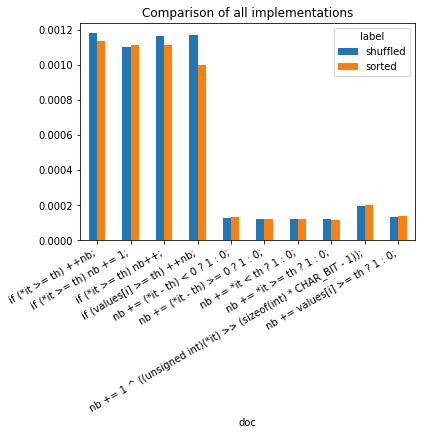

In [11]:
ax = dfg.plot.bar(rot=30)
labels = [l.get_text() for l in ax.get_xticklabels()]
ax.set_xticklabels(labels, ha='right')
ax.set_title("Comparison of all implementations");

It seems that inline tests (``cond ? value1 : value2``) do not stop the branching and it should be used whenever possible.

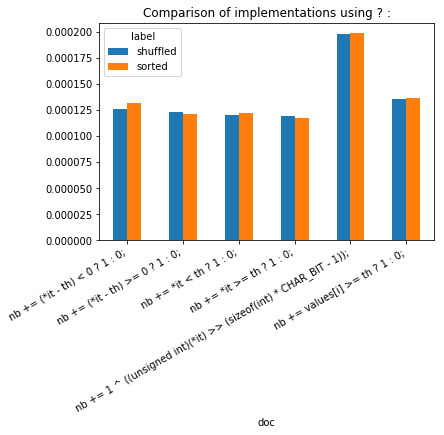

In [12]:
sdf = df[["doc", "label", "average"]]
dfg2 = sdf[sdf.doc.str.contains('[?^]')].pivot("doc", "label", "average")
ax = dfg2.plot.bar(rot=30)
labels = [l.get_text() for l in ax.get_xticklabels()]
ax.set_xticklabels(labels, ha='right')
ax.set_title("Comparison of implementations using ? :");

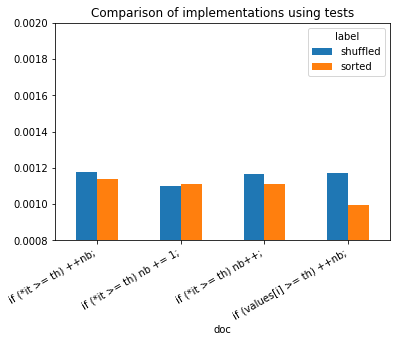

In [13]:
sdf = df[["doc", "label", "average"]]
dfg2 = sdf[sdf.doc.str.contains('if')].pivot("doc", "label", "average")
ax = dfg2.plot.bar(rot=30)
labels = [l.get_text() for l in ax.get_xticklabels()]
ax.set_xticklabels(labels, ha='right')
ax.set_ylim([0.0008, 0.0020])
ax.set_title("Comparison of implementations using tests");

*sorted*, *not sorted* does not seem to have a real impact in this case. It shows *branching* really slows down the execution of a program. Branching happens whenever the program meets a loop condition or a test. Iterator ``*it`` are faster than accessing an array with notation ``[i]`` which adds a cost due to an extra addition.

## Second experiment: dot product

The goal is to compare the dot product from [numpy.dot](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.dot.html) and a couple of implementation in C++ which look like this:

In [14]:
# float vector_dot_product_pointer(const float *p1, const float *p2, size_t size)
# {
#     float sum = 0;
#     const float * end1 = p1 + size;
#     for(; p1 != end1; ++p1, ++p2)
#         sum += *p1 * *p2;
#     return sum;
# }
# 
# 
# float vector_dot_product(py::array_t<float> v1, py::array_t<float> v2)
# {
#     if (v1.ndim() != v2.ndim())
#         throw std::runtime_error("Vector v1 and v2 must have the same dimension.");
#     if (v1.ndim() != 1)
#         throw std::runtime_error("Vector v1 and v2 must be vectors.");
#     return vector_dot_product_pointer(v1.data(0), v2.data(0), v1.shape(0));
# }

### numpy vs C++

In [15]:
%matplotlib inline

In [16]:
import numpy

def simple_dot(values):
    return numpy.dot(values, values)

values = list(range(10000000))
values = numpy.array(values, dtype=numpy.float32)
vect = values / numpy.max(values)
simple_dot(vect)

3333333.2

In [17]:
vect.dtype

dtype('float32')

In [18]:
from timeit import Timer

def measure_time(stmt, context, repeat=10, number=50):
    tim = Timer(stmt, globals=context)
    res = numpy.array(tim.repeat(repeat=repeat, number=number))
    mean = numpy.mean(res)
    dev = numpy.mean(res ** 2)
    dev = (dev - mean**2) ** 0.5
    return dict(average=mean, deviation=dev, min_exec=numpy.min(res),
                max_exec=numpy.max(res), repeat=repeat, number=number,
                size=context['values'].shape[0])

measure_time("simple_dot(values)", context=dict(simple_dot=simple_dot, values=vect))

{'average': 0.15912354850000837,
 'deviation': 0.004389782861004863,
 'min_exec': 0.15188136199998326,
 'max_exec': 0.16728480599999784,
 'repeat': 10,
 'number': 50,
 'size': 10000000}

In [19]:
res = []
for i in range(10, 200000, 2500):
    t = measure_time("simple_dot(values)", repeat=100,
                     context=dict(simple_dot=simple_dot, values=vect[:i].copy()))
    res.append(t)

import pandas
dot = pandas.DataFrame(res)
dot.tail()

,average,deviation,max_exec,min_exec,number,repeat,size
75,0.001825,0.000333,0.002845,0.001043,50,100,187510
76,0.001956,0.000725,0.005158,0.001111,50,100,190010
77,0.001838,0.000574,0.003753,0.001045,50,100,192510
78,0.001765,0.000461,0.003408,0.001056,50,100,195010
79,0.001899,0.000695,0.004939,0.001160,50,100,197510


In [20]:
res = []
for i in range(100000, 10000000, 1000000):
    t = measure_time("simple_dot(values)", repeat=10,
                     context=dict(simple_dot=simple_dot, values=vect[:i].copy()))
    res.append(t)
    
huge_dot = pandas.DataFrame(res)
huge_dot.head()

,average,deviation,max_exec,min_exec,number,repeat,size
0,0.000817,0.000040,0.000907,0.000770,50,10,100000
1,0.013630,0.001590,0.016657,0.011661,50,10,1100000
2,0.037408,0.002781,0.041095,0.031552,50,10,2100000
3,0.049072,0.003388,0.055567,0.044804,50,10,3100000
4,0.064704,0.001538,0.067962,0.062106,50,10,4100000


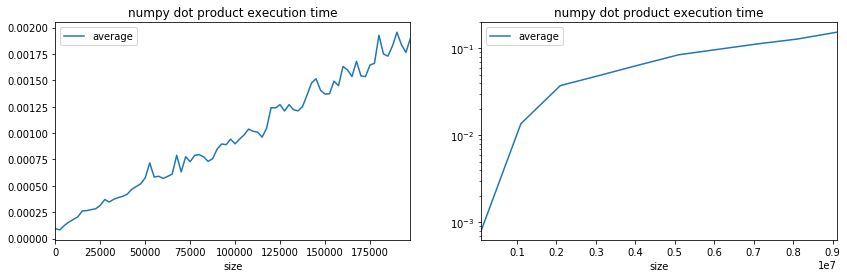

In [21]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(14,4))
dot.plot(x='size', y="average", ax=ax[0])
huge_dot.plot(x='size', y="average", ax=ax[1], logy=True)
ax[0].set_title("numpy dot product execution time");
ax[1].set_title("numpy dot product execution time");

Now the custom implementation. We start with an empty function to get a sense of the cost due to to pybind11.

In [22]:
from cpyquickhelper.numbers.cbenchmark_dot import empty_vector_dot_product
empty_vector_dot_product(vect, vect)

0.0

In [23]:
def empty_c11_dot(vect):
    return empty_vector_dot_product(vect, vect)

measure_time("empty_c11_dot(values)", context=dict(empty_c11_dot=empty_c11_dot, values=vect), repeat=10)

{'average': 0.00010773330000688475,
 'deviation': 2.4357745040527937e-05,
 'min_exec': 6.716000001460998e-05,
 'max_exec': 0.00014380200002506172,
 'repeat': 10,
 'number': 50,
 'size': 10000000}

Very small. It should not pollute our experiments.

In [24]:
from cpyquickhelper.numbers.cbenchmark_dot import vector_dot_product
vector_dot_product(vect, vect)

3334629.0

In [25]:
def c11_dot(vect):
    return vector_dot_product(vect, vect)

measure_time("c11_dot(values)", context=dict(c11_dot=c11_dot, values=vect), repeat=10)

{'average': 1.0864936006999983,
 'deviation': 0.042114970512102286,
 'min_exec': 0.9931970420000198,
 'max_exec': 1.1422908499999949,
 'repeat': 10,
 'number': 50,
 'size': 10000000}

In [26]:
res = []
for i in range(10, 200000, 2500):
    t = measure_time("c11_dot(values)", repeat=10,
                     context=dict(c11_dot=c11_dot, values=vect[:i].copy()))
    res.append(t)

import pandas
cus_dot = pandas.DataFrame(res)
cus_dot.tail()

,average,deviation,max_exec,min_exec,number,repeat,size
75,0.015233,0.001483,0.018811,0.013971,50,10,187510
76,0.018793,0.003738,0.024941,0.014803,50,10,190010
77,0.024152,0.001447,0.027682,0.021687,50,10,192510
78,0.022668,0.001428,0.024472,0.019594,50,10,195010
79,0.022919,0.002025,0.025360,0.018967,50,10,197510


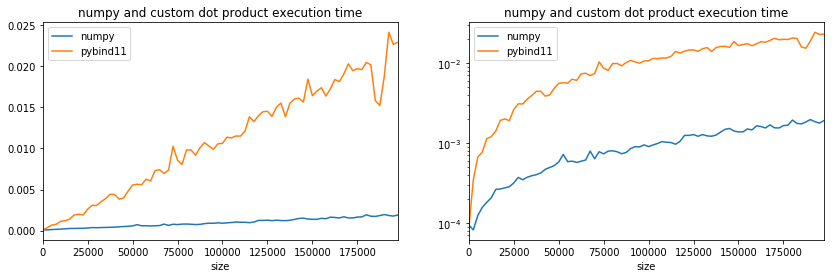

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(14,4))
dot.plot(x='size', y="average", ax=ax[0], label="numpy")
cus_dot.plot(x='size', y="average", ax=ax[0], label="pybind11")
dot.plot(x='size', y="average", ax=ax[1], label="numpy", logy=True)
cus_dot.plot(x='size', y="average", ax=ax[1], label="pybind11")
ax[0].set_title("numpy and custom dot product execution time");
ax[1].set_title("numpy and custom dot product execution time");

Pretty slow. Let's see what it does to compute dot product 16 by 16.

### BLAS

Internally, [numpy](http://www.numpy.org/) is using [BLAS](http://www.netlib.org/blas/). A direct call to it should give the same results.

In [28]:
from cpyquickhelper.numbers.direct_blas_lapack import cblas_sdot

def blas_dot(vect):
    return cblas_sdot(vect, vect)

measure_time("blas_dot(values)", context=dict(blas_dot=blas_dot, values=vect), repeat=10)

{'average': 0.1616296600000055,
 'deviation': 0.008257471136607717,
 'min_exec': 0.15190743599998768,
 'max_exec': 0.1832800530000327,
 'repeat': 10,
 'number': 50,
 'size': 10000000}

In [29]:
res = []
for i in range(10, 200000, 2500):
    t = measure_time("blas_dot(values)", repeat=10,
                     context=dict(blas_dot=blas_dot, values=vect[:i].copy()))
    res.append(t)

import pandas
blas_dot = pandas.DataFrame(res)
blas_dot.tail()

,average,deviation,max_exec,min_exec,number,repeat,size
75,0.001986,0.000253,0.002141,0.001257,50,10,187510
76,0.001791,0.000320,0.002167,0.001218,50,10,190010
77,0.001674,0.000321,0.002168,0.001297,50,10,192510
78,0.001711,0.000432,0.002237,0.001165,50,10,195010
79,0.001891,0.000296,0.002265,0.001369,50,10,197510


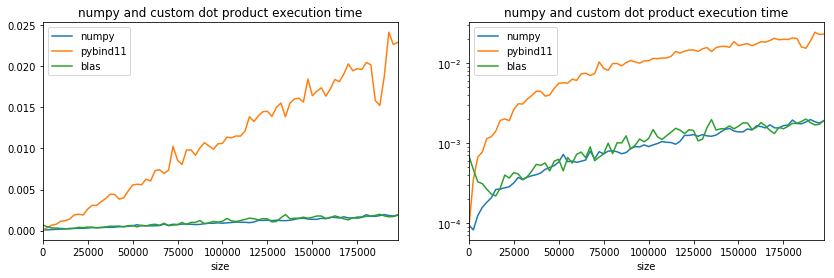

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(14,4))
dot.plot(x='size', y="average", ax=ax[0], label="numpy")
cus_dot.plot(x='size', y="average", ax=ax[0], label="pybind11")
blas_dot.plot(x='size', y="average", ax=ax[0], label="blas")
dot.plot(x='size', y="average", ax=ax[1], label="numpy", logy=True)
cus_dot.plot(x='size', y="average", ax=ax[1], label="pybind11")
blas_dot.plot(x='size', y="average", ax=ax[1], label="blas")
ax[0].set_title("numpy and custom dot product execution time");
ax[1].set_title("numpy and custom dot product execution time");

### Use of branching: 16 multplications in one row

The code looks like what follows. If there is more than 16 multiplications left, we use function *vector_dot_product_pointer16*, otherwise, there are done one by one like the previous function.

In [31]:
# float vector_dot_product_pointer16(const float *p1, const float *p2)
# {
#     float sum = 0;
#     
#     sum += *(p1++) * *(p2++);
#     sum += *(p1++) * *(p2++);
#     sum += *(p1++) * *(p2++);
#     sum += *(p1++) * *(p2++);
#     sum += *(p1++) * *(p2++);
#     sum += *(p1++) * *(p2++);
#     sum += *(p1++) * *(p2++);
#     sum += *(p1++) * *(p2++);
# 
#     sum += *(p1++) * *(p2++);
#     sum += *(p1++) * *(p2++);
#     sum += *(p1++) * *(p2++);
#     sum += *(p1++) * *(p2++);
#     sum += *(p1++) * *(p2++);
#     sum += *(p1++) * *(p2++);
#     sum += *(p1++) * *(p2++);
#     sum += *(p1++) * *(p2++);
# 
#     return sum;
# }
# 
# #define BYN 16
# 
# float vector_dot_product_pointer16(const float *p1, const float *p2, size_t size)
# {
#     float sum = 0;
#     size_t i = 0;
#     if (size >= BYN) {
#         size_t size_ = size - BYN;
#         for(; i < size_; i += BYN, p1 += BYN, p2 += BYN)
#             sum += vector_dot_product_pointer16(p1, p2);
#     }
#     for(; i < size; ++p1, ++p2, ++i)
#         sum += *p1 * *p2;
#     return sum;
# }
# 
# float vector_dot_product16(py::array_t<float> v1, py::array_t<float> v2)
# {
#     if (v1.ndim() != v2.ndim())
#         throw std::runtime_error("Vector v1 and v2 must have the same dimension.");
#     if (v1.ndim() != 1)
#         throw std::runtime_error("Vector v1 and v2 must be vectors.");
#     return vector_dot_product_pointer16(v1.data(0), v2.data(0), v1.shape(0));
# }

In [32]:
from cpyquickhelper.numbers.cbenchmark_dot import vector_dot_product16
vector_dot_product16(vect, vect)

3333331.75

In [33]:
def c11_dot16(vect):
    return vector_dot_product16(vect, vect)

measure_time("c11_dot16(values)", context=dict(c11_dot16=c11_dot16, values=vect), repeat=10)

{'average': 0.5281810741000073,
 'deviation': 0.012226152774555453,
 'min_exec': 0.5138093719999688,
 'max_exec': 0.5604131869999947,
 'repeat': 10,
 'number': 50,
 'size': 10000000}

In [34]:
res = []
for i in range(10, 200000, 2500):
    t = measure_time("c11_dot16(values)", repeat=10,
                     context=dict(c11_dot16=c11_dot16, values=vect[:i].copy()))
    res.append(t)

cus_dot16 = pandas.DataFrame(res)
cus_dot16.tail()

,average,deviation,max_exec,min_exec,number,repeat,size
75,0.009924,0.000532,0.010651,0.008707,50,10,187510
76,0.009555,0.000616,0.010573,0.008759,50,10,190010
77,0.009795,0.000584,0.010818,0.008984,50,10,192510
78,0.010344,0.000511,0.011001,0.009142,50,10,195010
79,0.010396,0.000958,0.011471,0.008140,50,10,197510


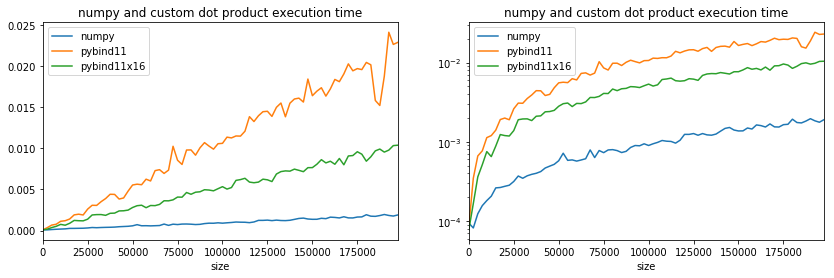

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(14,4))
dot.plot(x='size', y="average", ax=ax[0], label="numpy")
cus_dot.plot(x='size', y="average", ax=ax[0], label="pybind11")
cus_dot16.plot(x='size', y="average", ax=ax[0], label="pybind11x16")
dot.plot(x='size', y="average", ax=ax[1], label="numpy", logy=True)
cus_dot.plot(x='size', y="average", ax=ax[1], label="pybind11")
cus_dot16.plot(x='size', y="average", ax=ax[1], label="pybind11x16")
ax[0].set_title("numpy and custom dot product execution time");
ax[1].set_title("numpy and custom dot product execution time");

We are far from *numpy* but the branching has clearly a huge impact and the fact the loop condition is evaluated only every 16 iterations does not explain this gain. Next experiment with [SSE](https://fr.wikipedia.org/wiki/Streaming_SIMD_Extensions) instructions.

### Optimized to remove function call

We remove the function call to get the following version.

In [36]:
# float vector_dot_product_pointer16_nofcall(const float *p1, const float *p2, size_t size)
# {
#     float sum = 0;    
#     const float * end = p1 + size;
#     if (size >= BYN) {
#         #if(BYN != 16)
#             #error "BYN must be equal to 16";
#         #endif
#         unsigned int size_ = (unsigned int) size;
#         size_ = size_ >> 4;  // division by 16=2^4
#         size_ = size_ << 4;  // multiplication by 16=2^4
#         const float * end_ = p1 + size_;
#         for(; p1 != end_;)
#         {
#             sum += *p1 * *p2; ++p1, ++p2;
#             sum += *p1 * *p2; ++p1, ++p2;
#             sum += *p1 * *p2; ++p1, ++p2;
#             sum += *p1 * *p2; ++p1, ++p2;
#             
#             sum += *p1 * *p2; ++p1, ++p2;
#             sum += *p1 * *p2; ++p1, ++p2;
#             sum += *p1 * *p2; ++p1, ++p2;
#             sum += *p1 * *p2; ++p1, ++p2;
# 
#             sum += *p1 * *p2; ++p1, ++p2;
#             sum += *p1 * *p2; ++p1, ++p2;
#             sum += *p1 * *p2; ++p1, ++p2;
#             sum += *p1 * *p2; ++p1, ++p2;
#             
#             sum += *p1 * *p2; ++p1, ++p2;
#             sum += *p1 * *p2; ++p1, ++p2;
#             sum += *p1 * *p2; ++p1, ++p2;
#             sum += *p1 * *p2; ++p1, ++p2;
#         }
#     }
#     for(; p1 != end; ++p1, ++p2)
#         sum += *p1 * *p2;
#     return sum;
# }
# 
# float vector_dot_product16_nofcall(py::array_t<float> v1, py::array_t<float> v2)
# {
#     if (v1.ndim() != v2.ndim())
#         throw std::runtime_error("Vector v1 and v2 must have the same dimension.");
#     if (v1.ndim() != 1)
#         throw std::runtime_error("Vector v1 and v2 must be vectors.");
#     return vector_dot_product_pointer16_nofcall(v1.data(0), v2.data(0), v1.shape(0));
# }

In [37]:
from cpyquickhelper.numbers.cbenchmark_dot import vector_dot_product16_nofcall
vector_dot_product16_nofcall(vect, vect)

3334629.0

In [38]:
def c11_dot16_nofcall(vect):
    return vector_dot_product16_nofcall(vect, vect)

measure_time("c11_dot16_nofcall(values)",
             context=dict(c11_dot16_nofcall=c11_dot16_nofcall, values=vect), repeat=10)

{'average': 1.1714699287000259,
 'deviation': 0.023601121453714912,
 'min_exec': 1.112935812000046,
 'max_exec': 1.2079828480000288,
 'repeat': 10,
 'number': 50,
 'size': 10000000}

In [39]:
res = []
for i in range(10, 200000, 2500):
    t = measure_time("c11_dot16_nofcall(values)", repeat=10,
                     context=dict(c11_dot16_nofcall=c11_dot16_nofcall, values=vect[:i].copy()))
    res.append(t)

cus_dot16_nofcall = pandas.DataFrame(res)
cus_dot16_nofcall.tail()

,average,deviation,max_exec,min_exec,number,repeat,size
75,0.022504,0.001032,0.024698,0.020807,50,10,187510
76,0.021753,0.001856,0.025182,0.018921,50,10,190010
77,0.020330,0.001574,0.022484,0.018413,50,10,192510
78,0.024797,0.003121,0.032145,0.021938,50,10,195010
79,0.021374,0.001674,0.023559,0.018869,50,10,197510


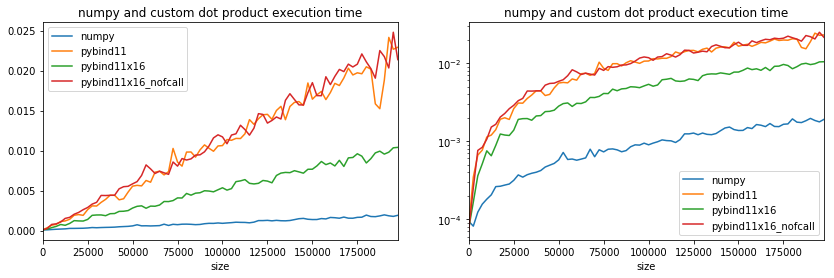

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(14,4))
dot.plot(x='size', y="average", ax=ax[0], label="numpy")
cus_dot.plot(x='size', y="average", ax=ax[0], label="pybind11")
cus_dot16.plot(x='size', y="average", ax=ax[0], label="pybind11x16")
cus_dot16_nofcall.plot(x='size', y="average", ax=ax[0], label="pybind11x16_nofcall")
dot.plot(x='size', y="average", ax=ax[1], label="numpy", logy=True)
cus_dot.plot(x='size', y="average", ax=ax[1], label="pybind11")
cus_dot16.plot(x='size', y="average", ax=ax[1], label="pybind11x16")
cus_dot16_nofcall.plot(x='size', y="average", ax=ax[1], label="pybind11x16_nofcall")
ax[0].set_title("numpy and custom dot product execution time");
ax[1].set_title("numpy and custom dot product execution time");

Weird, branching did not happen when the code is not inside a separate function.

### SSE instructions

We replace one function in the previous implementation.

In [41]:
# #include <xmmintrin.h>
# 
# float vector_dot_product_pointer16_sse(const float *p1, const float *p2)
# {
#     __m128 c1 = _mm_load_ps(p1);
#     __m128 c2 = _mm_load_ps(p2);
#     __m128 r1 = _mm_mul_ps(c1, c2);
#     
#     p1 += 4;
#     p2 += 4;
#     
#     c1 = _mm_load_ps(p1);
#     c2 = _mm_load_ps(p2);
#     r1 = _mm_add_ps(r1, _mm_mul_ps(c1, c2));
#     
#     p1 += 4;
#     p2 += 4;
#     
#     c1 = _mm_load_ps(p1);
#     c2 = _mm_load_ps(p2);
#     r1 = _mm_add_ps(r1, _mm_mul_ps(c1, c2));
#     
#     p1 += 4;
#     p2 += 4;
#     
#     c1 = _mm_load_ps(p1);
#     c2 = _mm_load_ps(p2);
#     r1 = _mm_add_ps(r1, _mm_mul_ps(c1, c2));
# 
#     float r[4];
#     _mm_store_ps(r, r1);
# 
#     return r[0] + r[1] + r[2] + r[3];
# }

In [42]:
from cpyquickhelper.numbers.cbenchmark_dot import vector_dot_product16_sse
vector_dot_product16_sse(vect, vect)

3333332.0

In [43]:
def c11_dot16_sse(vect):
    return vector_dot_product16_sse(vect, vect)

measure_time("c11_dot16_sse(values)", context=dict(c11_dot16_sse=c11_dot16_sse, values=vect), repeat=10)

{'average': 0.2237774429999945,
 'deviation': 0.023544418873161967,
 'min_exec': 0.20292606199996044,
 'max_exec': 0.2891375500000777,
 'repeat': 10,
 'number': 50,
 'size': 10000000}

In [44]:
res = []
for i in range(10, 200000, 2500):
    t = measure_time("c11_dot16_sse(values)", repeat=10,
                     context=dict(c11_dot16_sse=c11_dot16_sse, values=vect[:i].copy()))
    res.append(t)

cus_dot16_sse = pandas.DataFrame(res)
cus_dot16_sse.tail()

,average,deviation,max_exec,min_exec,number,repeat,size
75,0.003277,0.000450,0.003724,0.002355,50,10,187510
76,0.003784,0.000557,0.005109,0.003118,50,10,190010
77,0.003541,0.000874,0.005640,0.002325,50,10,192510
78,0.003505,0.000479,0.003947,0.002496,50,10,195010
79,0.003530,0.000373,0.004012,0.002783,50,10,197510


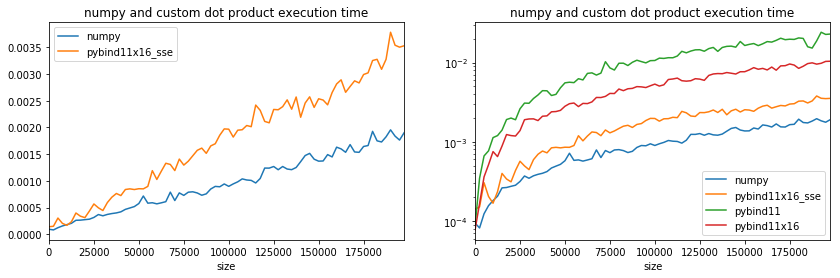

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(14,4))
dot.plot(x='size', y="average", ax=ax[0], label="numpy")
cus_dot16_sse.plot(x='size', y="average", ax=ax[0], label="pybind11x16_sse")
dot.plot(x='size', y="average", ax=ax[1], label="numpy", logy=True)
cus_dot16_sse.plot(x='size', y="average", ax=ax[1], label="pybind11x16_sse")
cus_dot.plot(x='size', y="average", ax=ax[1], label="pybind11")
cus_dot16.plot(x='size', y="average", ax=ax[1], label="pybind11x16")
ax[0].set_title("numpy and custom dot product execution time");
ax[1].set_title("numpy and custom dot product execution time");

Better even though it is still slower than *numpy*. It is closer. Maybe the compilation option are not optimized, *numpy* was also compiled with the Intel compiler. To be accurate, multi-threading must be disabled on *numpy* side. That's the purpose of the first two lines.

### AVX 512

Last experiment with [AVX 512](https://fr.wikipedia.org/wiki/Advanced_Vector_Extensions) instructions but it does not work on all processor. I could not test it on my laptop as these instructions do not seem to be available. More can be found on wikipedia [CPUs with AVX-512](https://en.wikipedia.org/wiki/AVX-512#CPUs_with_AVX-512).

In [46]:
import platform
platform.processor()

'Intel64 Family 6 Model 78 Stepping 3, GenuineIntel'

In [47]:
import numpy
values = numpy.array(list(range(10000000)), dtype=numpy.float32)
vect = values / numpy.max(values)

In [48]:
from cpyquickhelper.numbers.cbenchmark_dot import vector_dot_product16_avx512
vector_dot_product16_avx512(vect, vect)

3333332.0

In [49]:
def c11_dot16_avx512(vect):
    return vector_dot_product16_avx512(vect, vect)

measure_time("c11_dot16_avx512(values)",
             context=dict(c11_dot16_avx512=c11_dot16_avx512, values=vect), repeat=10)

{'average': 0.2209936032000087,
 'deviation': 0.01601067795994051,
 'min_exec': 0.19949021299999004,
 'max_exec': 0.25032987700001286,
 'repeat': 10,
 'number': 50,
 'size': 10000000}

In [50]:
res = []
for i in range(10, 200000, 2500):
    t = measure_time("c11_dot16_avx512(values)", repeat=10,
                     context=dict(c11_dot16_avx512=c11_dot16_avx512, values=vect[:i].copy()))
    res.append(t)

cus_dot16_avx512 = pandas.DataFrame(res)
cus_dot16_avx512.tail()

,average,deviation,max_exec,min_exec,number,repeat,size
75,0.003197,0.000532,0.003852,0.002329,50,10,187510
76,0.004724,0.001165,0.005950,0.003041,50,10,190010
77,0.002940,0.000354,0.003700,0.002442,50,10,192510
78,0.003305,0.000575,0.004290,0.002413,50,10,195010
79,0.003080,0.000438,0.004048,0.002546,50,10,197510


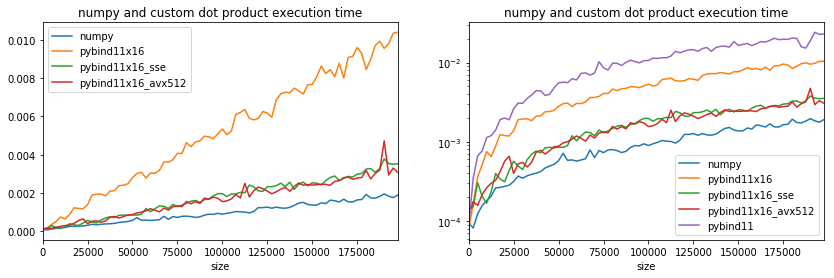

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(14,4))
dot.plot(x='size', y="average", ax=ax[0], label="numpy")
cus_dot16.plot(x='size', y="average", ax=ax[0], label="pybind11x16")
cus_dot16_sse.plot(x='size', y="average", ax=ax[0], label="pybind11x16_sse")
cus_dot16_avx512.plot(x='size', y="average", ax=ax[0], label="pybind11x16_avx512")
dot.plot(x='size', y="average", ax=ax[1], label="numpy", logy=True)
cus_dot16.plot(x='size', y="average", ax=ax[1], label="pybind11x16")
cus_dot16_sse.plot(x='size', y="average", ax=ax[1], label="pybind11x16_sse")
cus_dot16_avx512.plot(x='size', y="average", ax=ax[1], label="pybind11x16_avx512")
cus_dot.plot(x='size', y="average", ax=ax[1], label="pybind11")
ax[0].set_title("numpy and custom dot product execution time");
ax[1].set_title("numpy and custom dot product execution time");

If the time is the same, it means that options AVX512 are not available.

In [52]:
from cpyquickhelper.numbers.cbenchmark import get_simd_available_option
get_simd_available_option()

'Available options:  __SSE__ __SSE2__ __SSE3__ __SSE4_1__'

### Back to numpy

This article [Why is matrix multiplication faster with numpy than with ctypes in Python?](https://stackoverflow.com/questions/10442365/why-is-matrix-multiplication-faster-with-numpy-than-with-ctypes-in-python) gives some kints on why *numpy* is still faster. By looking at the code of the dot product in *numpy*: [arraytypes.c.src](https://github.com/numpy/numpy/blob/master/numpy/core/src/multiarray/arraytypes.c.src), it seems that *numpy* does a simple dot product without using branching or uses the library [BLAS](http://www.netlib.org/blas/) which is the case in this benchmark (code for dot product: [sdot.c](http://www.netlib.org/clapack/cblas/sdot.c)). And it does use *branching*. See also function [blas_stride](https://github.com/numpy/numpy/blob/master/numpy/core/src/multiarray/common.h#L298). These libraries then play with [compilation options](https://gcc.gnu.org/onlinedocs/gcc/Optimize-Options.html) and optimize for speed. This benchmark does not look into [cython-blis](https://github.com/explosion/cython-blis) which implements some [BLAS](http://www.netlib.org/blas/) functions with an assembly language and has different implementations depending on the platform it is used.